<a href="https://colab.research.google.com/github/adithyanum/disease_prediction_from_symptoms/blob/main/disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Disease Prediction from Symptoms using BERT + Random Forest

This project aims to predict the most likely disease(s) based on a given set of symptoms. We utilize a powerful combination of **BERT embeddings** to understand symptom descriptions and a **Random Forest classifier** for final prediction.

This model will later be deployed in a real-time application to assist users or practitioners by suggesting possible diseases and identifying critical symptoms.


## 📂 Dataset Overview

We use a symptom-based disease classification dataset from Kaggle that includes:

- `dataset.csv`: List of symptoms for each disease
- `Symptom_severity.csv`: Maps symptoms to severity scores
- `symptom_Description.csv`: Text descriptions of symptoms
- `symptom_precaution.csv`: Recommended precautions per disease

We'll primarily work with `dataset.csv` to train the model.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/disease_symptom_dataset/dataset.csv")
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 📊 Initial Data Inspection

Each row in the dataset corresponds to a patient case with up to 17 symptoms and a diagnosis (disease). The symptoms are spread across multiple columns. We combine them into a single text column for easier processing and BERT input.


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [ ]:
df.isnull().sum()

,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,348
Symptom_5,1206
Symptom_6,1986
Symptom_7,2652
Symptom_8,2976
Symptom_9,3228


In [ ]:
df['all_symptoms'] = df.iloc[:, 1:].apply(lambda x : ','.join(x.dropna().astype(str)), axis = 1)
df[['Disease', 'all_symptoms']].head()

,Disease,all_symptoms
0,Fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,Fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _..."
2,Fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,Fungal infection,"itching, skin_rash, dischromic _patches"
4,Fungal infection,"itching, skin_rash, nodal_skin_eruptions"


## 🧹 Cleaning Symptom Texts

We merge all symptom columns into one string, replace missing values, remove underscores, strip spaces, and convert everything to lowercase.

This ensures consistency for semantic embedding generation using BERT.


In [ ]:
import re

In [ ]:
df['all_symptoms'] = df['all_symptoms'].apply(lambda x: re.sub(r'\s+', ' ', re.sub(r'_', ' ', x)).strip().lower())

## 🔖 Encoding Disease Labels

Since machine learning models work with numeric labels, we convert disease names into integers using `LabelEncoder`. This is essential for classification and will later help us decode predicted outputs back to disease names.


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
df['encoded_disease'] = label_encoder.fit_transform(df['Disease'])

print("Original Labels : ", df['Disease'].unique()[:5])
print("\nEncoded Labels : ", df['encoded_disease'].unique()[:5])

Original Labels :  ['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction']

Encoded Labels :  [15  4 16  9 14]


In [ ]:
encoded_labels = df['encoded_disease']

In [ ]:
label_encoder.inverse_transform([4])

array(['Allergy'], dtype=object)

## 🧠 Converting Symptoms into Tokens using BERT

We use Hugging Face’s `bert-base-uncased` tokenizer to tokenize our merged symptom strings. The tokenizer handles:
- Padding
- Attention masks
- Truncation

This step prepares the input format required by BERT.


In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
encoded_input = tokenizer(
    df['all_symptoms'].tolist(),
    padding = True,
    truncation = True,
    max_length = 120,
    return_tensors = 'pt'
)

## 📐 Creating Embeddings from BERT

We pass the tokenized inputs into the pre-trained BERT model and extract the `[CLS]` token embedding from each output. This gives us a fixed-size (768-dim) vector representing the entire symptom set semantically.


In [ ]:
import torch

with torch.no_grad() :
    outputs = bert_model(**encoded_input)

In [ ]:
X = outputs.last_hidden_state[:,0,:]

In [ ]:
X.shape

torch.Size([4920, 768])

In [ ]:
y_tensor = torch.tensor(encoded_labels.values)

## 🔍 Splitting the Dataset

We split the embeddings and encoded labels into training and testing sets (80%/20%) with stratification to ensure class balance. These are used to train and evaluate the classifier.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_tensor,
    test_size = 0.2,
    stratify = y_tensor,
    random_state = 42
)

In [ ]:
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: torch.Size([3936, 768])
Test Set Shape: torch.Size([984, 768])


## 🎯 Training the Classifier

We train a `RandomForestClassifier` using the 768-dimensional BERT embeddings. Random Forest is chosen for its robustness, interpretability, and ability to handle tabular data derived from text features.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_np, y_train)
print("Model Training complete!")

Model Training complete!


## ✅ Model Evaluation

We evaluate the trained model using:
- **Accuracy Score**
- **Classification Report** (Precision, Recall, F1-score)
- **Confusion Matrix**

High performance indicates the model has learned strong associations between symptom embeddings and diseases.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score : ", round(accuracy, 4))

classification = classification_report(y_test,y_pred, target_names = label_encoder.classes_)
print("\nClassification Report : \n", classification)

confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix : \n", confusion)



Accuracy Score :  1.0

Classification Report : 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.0

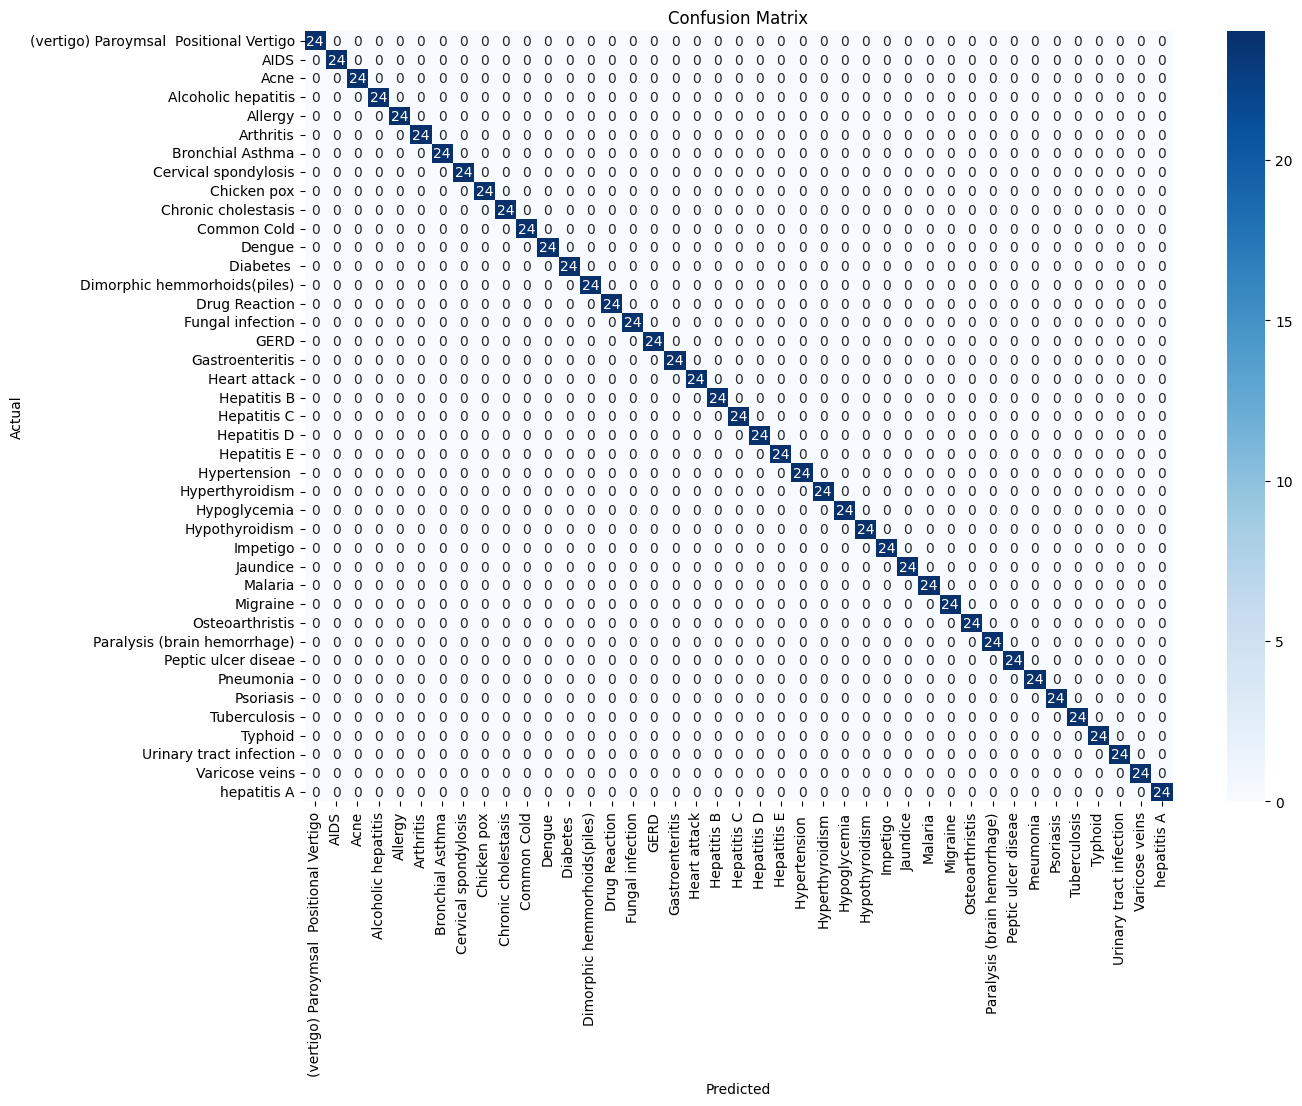

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(confusion, annot =True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 📈 Final Results

**Model Accuracy on Test Set**: `100%`

The classification report indicates excellent performance:

- **Precision**: 1.00
- **Recall**: 1.00
- **F1-Score**: 1.00

All 41 diseases were predicted perfectly in the test set. This high performance is likely due to:
- Structured and synthetic nature of the dataset (limited variation),
- Powerful embeddings from pre-trained BERT,
- Robustness of Random Forests.

> ⚠️ **Note**: In real-world scenarios, data will be more noisy and imbalanced. Additional steps like data augmentation, domain adaptation, or human-in-the-loop validation would be required.


## 🙏 Acknowledgments

- **Dataset Source**: [Kaggle - Disease Prediction from Symptoms Dataset](https://www.kaggle.com/datasets/prasoonkottarathil/disease-prediction-from-symptoms)
- **Transformer Models**: [HuggingFace Transformers](https://huggingface.co/transformers/)
- **Model Training**: Powered by `scikit-learn`, `transformers`, and `PyTorch`.

Special thanks to the open-source community for providing these tools and resources. This project would not have been possible without them.


In [ ]:
import joblib

# Save Random Forest model
joblib.dump(rf_model, '/content/drive/MyDrive/disease_predictor/rf_disease_model.joblib')

# Save Label Encoder
joblib.dump(label_encoder, '/content/drive/MyDrive/disease_predictor/label_encoder.joblib')


['/content/drive/MyDrive/disease_predictor/label_encoder.joblib']

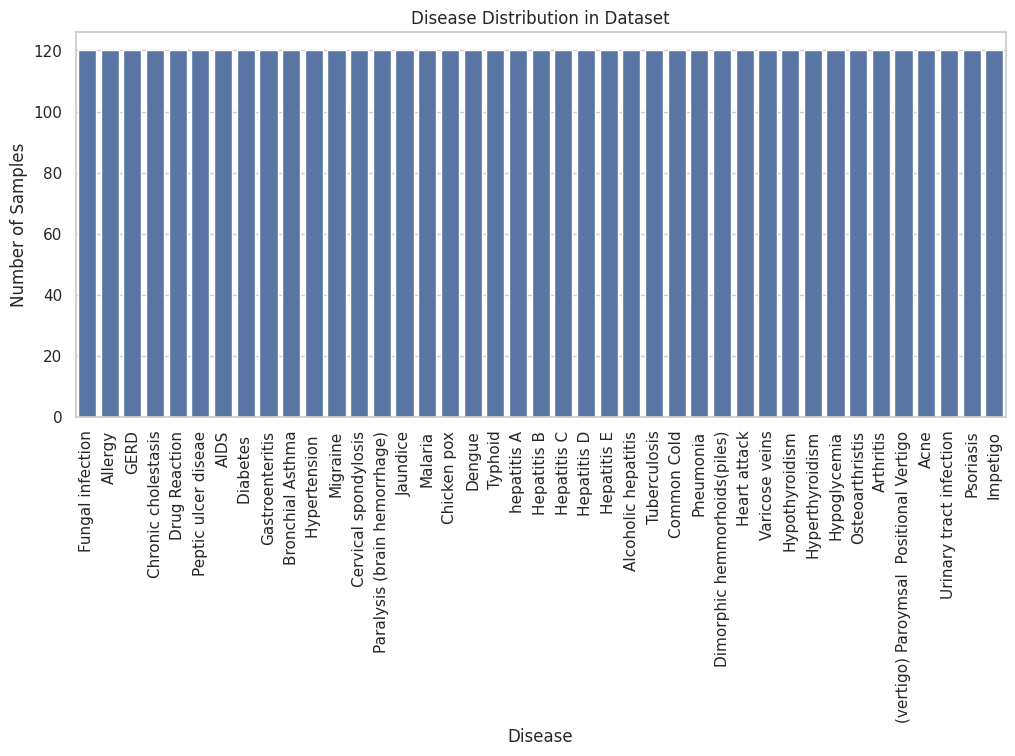

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you used a DataFrame like 'df' to train the model
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="Disease", order=df["Disease"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Disease Distribution in Dataset")
plt.ylabel("Number of Samples")
plt.show()
